In [4]:
import importlib
from SpLSI import generate_topic_model as gen_model
from SpLSI import utils 
from SpLSI import splsi_
import numpy as np
import pandas as pd
import networkx as nx
import community as community_louvain  
from sklearn.metrics.pairwise import euclidean_distances
from scipy.sparse.linalg import svds
import matplotlib.pyplot as plt
from types import SimpleNamespace
import time
import statistics
import contextlib
import random
import os
import sys
import warnings
import community as community_louvain  

/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
import rpy2.robjects as robjects
import rpy2.robjects.packages as rpackages
from rpy2.robjects import pandas2ri
from rpy2.robjects import numpy2ri

In [175]:
importlib.reload(gen_model)
importlib.reload(splsi_)
importlib.reload(utils)

<module 'SpLSI.utils' from '/Users/zhangzeyu/Downloads/research/SpLSI/SpLSI/utils.py'>

In [409]:
def simulation(k=4, iteration=10):
    acc_spectral = []
    time_spectral = []
    acc_bayes = []
    time_bayes = []
    acc_spatial = []
    time_spatial = []
    acc_pca = []

    for i in range(iteration):
        random.seed(123+i)
        coords_df = gen_model.generate_graph(100, 1000, 30, k, 0.05)
        W = gen_model.generate_W_strong(coords_df, 100, 1000, 30, k, 0.05) 
        L = np.diag(np.random.rand(min(W.shape)))
        V, _ = np.linalg.qr(np.random.randn(30, W.shape[0])) # fix p = 30
        X = W.T @ L @ V.T
        # X = X + np.random.normal(0, 0.02, X.shape)
        X = utils.euclidean_proj_simplex(X, s=1)
        X = utils.multinomial_from_rows(X,n=100)

        ### SpatialSVD and Regular PCA
        weights, edge_df = gen_model.generate_weights_edge(coords_df, 4, 0.05)
        start_time_1 = time.time()
        model_hooi = splsi_.SpLSI_(lamb_start=0.001,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-05,normalize=True,L_inv_=True)
        model_hooi.fit(X, k, edge_df, weights)
        end_time_1 = time.time()
        running_time_1 = end_time_1 - start_time_1

        U = model_hooi.U
        V_hat = model_hooi.V
        acc_spectral.append(utils.group_and_compare_spectral(U, coords_df))
        time_spectral.append(running_time_1)
        U_svd, _, _ = svds(X.astype(float), k=k)
        acc_pca.append(utils.group_and_compare_spectral(U_svd, coords_df))


        robjects.globalenv['k'] = k

        ### BayesSpace
        pandas2ri.activate()
        numpy2ri.activate()
        SingleCellExperiment = rpackages.importr('SingleCellExperiment')
        BayesSpace = rpackages.importr('BayesSpace')

        coords_df_r = coords_df.iloc[:, :2]
        coords_df_r.columns = ['row', 'col']
        location_df_r = pandas2ri.py2rpy(coords_df_r)

        robjects.globalenv['counts_matrix'] = X.T 
        robjects.globalenv['location_df'] = location_df_r

        start_time_2 = time.time()
        robjects.r('''
        rownames(counts_matrix) <- 1:nrow(counts_matrix)
        colnames(counts_matrix) <- 1:ncol(counts_matrix)
        rownames(location_df) <- 1:ncol(counts_matrix)

        sce <- SingleCellExperiment(
        assays = list(counts = counts_matrix),
        colData = location_df
        )

        sce <- spatialPreprocess(sce, platform = "ST", 
                                n.PCs = k, n.HVGs = 2000, log.normalize = TRUE)

        sce <- spatialCluster(sce, q = 4, platform = "ST", d = 7,
                            init.method = "mclust", model = "t", gamma = 2,
                            nrep = 10000, burn.in = 100, save.chain = TRUE)
        ''')
        end_time_2 = time.time()
        running_time_2 = end_time_2 - start_time_2
        time_bayes.append(running_time_2)

        clusters = robjects.r('sce$spatial.cluster')
        acc_bayes.append(utils.get_accuracy(clusters-1, coords_df))


        ### SpatialPCA
        counts = X.T  
        location = coords_df.iloc[:, :2].to_numpy()  

        counts_r = numpy2ri.py2rpy(counts)
        location_r = numpy2ri.py2rpy(location)
        robjects.globalenv['counts_r'] = counts_r
        robjects.globalenv['location_r'] = location_r

        robjects.r('rownames(counts_r) <- 1:nrow(counts_r)')
        robjects.r('colnames(counts_r) <- 1:ncol(counts_r)')
        robjects.r('rownames(location_r) <- 1:nrow(location_r)')

        start_time_3 = time.time()
        robjects.r('''
        library(SpatialPCA)

        ST <- CreateSpatialPCAObject(counts = counts_r,
            location = location_r,
            project = "SpatialPCA",
            gene.type = "spatial",
            sparkversion = "spark",
            min.loctions = 2,
            min.features = 10
        )

        ST <- SpatialPCA_buildKernel(
            ST,
            kerneltype = "gaussian",
            bandwidthtype = "SJ"
        )

        ST <- SpatialPCA_EstimateLoading(
            ST,
            fast = FALSE,
            SpatialPCnum = k
        )

        ST <- SpatialPCA_SpatialPCs(
            ST,
            fast = FALSE
        )
        ''')
        end_time_3 = time.time()
        running_time_3 = end_time_3 - start_time_3
        time_spatial.append(running_time_3)

        SpatialPC = robjects.r('ST@SpatialPCs')
        acc_spatial.append(utils.group_and_compare_spectral(SpatialPC.T, coords_df))

    return SimpleNamespace(acc_spectral=statistics.mean(acc_spectral), time_spectral=statistics.mean(time_spectral), acc_pca=statistics.mean(acc_pca),
                           acc_bayes=statistics.mean(acc_bayes), time_bayes=statistics.mean(time_bayes),
                           acc_spatial=statistics.mean(acc_spatial), time_spatial=statistics.mean(time_spatial))



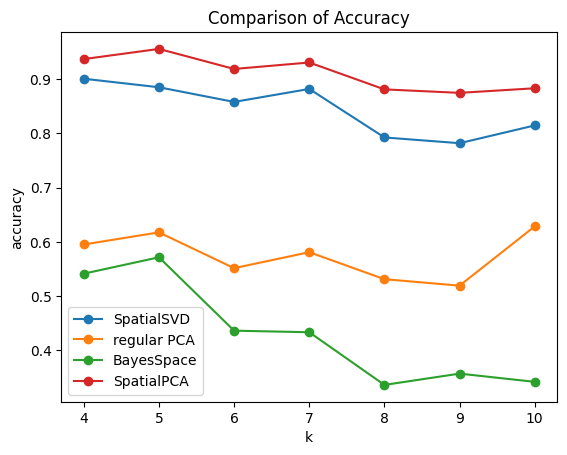

In [431]:
results = [result_4, result_5, result_6, result_7, result_8, result_9, result_10]

plt.plot(range(4, 11), [result.acc_spectral for result in results], marker='o', label='SpatialSVD')
plt.plot(range(4, 11), [result.acc_pca for result in results], marker='o', label='regular PCA')
plt.plot(range(4, 11), [result.acc_bayes for result in results], marker='o', label='BayesSpace')
plt.plot(range(4, 11), [result.acc_spatial for result in results], marker='o', label='SpatialPCA')

plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Comparison of Accuracy')
plt.legend()
plt.show()

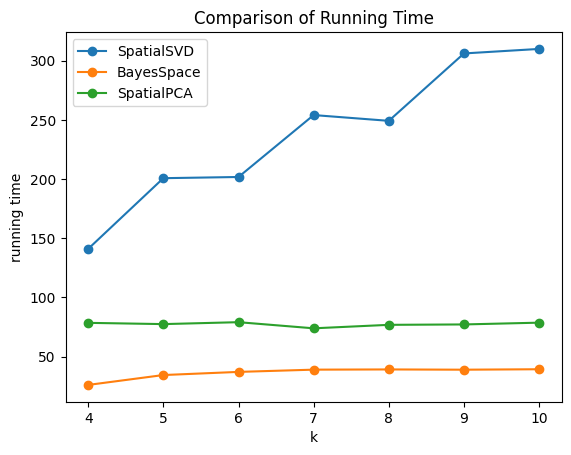

In [433]:
plt.plot(range(4, 11), [result.time_spectral for result in results], marker='o', label='SpatialSVD')
plt.plot(range(4, 11), [result.time_bayes for result in results], marker='o', label='BayesSpace')
plt.plot(range(4, 11), [result.time_spatial for result in results], marker='o', label='SpatialPCA')

plt.xlabel('k')
plt.ylabel('running time')
plt.title('Comparison of Running Time')
plt.legend()
plt.show()

## K = 4

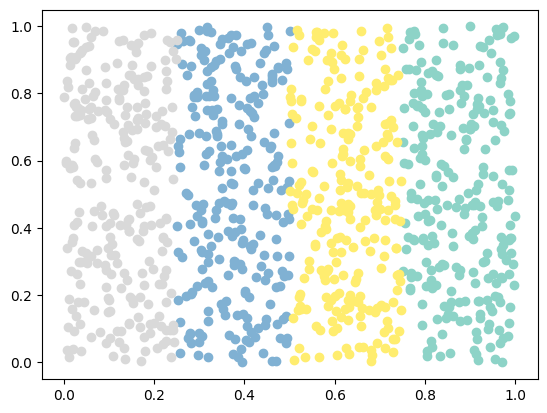

In [399]:
coords_df_4 = gen_model.generate_graph(100, 1000, 30, 4, 0.05)
gen_model.plot_scatter(coords_df_4)
W_4 = gen_model.generate_W_strong(coords_df_4, 100, 1000, 30, 4, 0.05) 
L_4 = np.diag(np.random.rand(min(W_4.shape)))
V_4, _ = np.linalg.qr(np.random.randn(30, W_4.shape[0])) # fix p = 30
X_4 = W_4.T @ L_4 @ V_4.T
# X_4 = X_4 + np.random.normal(0, 0.02, X_4.shape)
X_4 = utils.euclidean_proj_simplex(X_4, s=1)
X_4 = utils.multinomial_from_rows(X_4,n=100)

In [400]:
weights_4, edge_df_4 = gen_model.generate_weights_edge(coords_df_4, 4, 0.05)
model_hooi_4 = splsi_.SpLSI_(lamb_start=0.001,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-05,normalize=True,L_inv_=True)
model_hooi_4.fit(X_4, 4, edge_df_4, weights_4)

Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Optimal lambda is 0.038443359375...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.06624737266949231...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.09539621664406893...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.07949684720339077...
SpatialSVD ran for 7 steps.
Running SPOC...


In [401]:
U_4 = model_hooi_4.U
V_hat_4 = model_hooi_4.V

In [402]:
acc_4_spectral = utils.group_and_compare_spectral(U_4, coords_df_4)
print(f"Clustering Accuracy for Spatial PCA: {acc_4_spectral:.2f}")
U_44, _, _ = svds(X_4.astype(float), k=4)
acc_4_pca_spectral = utils.group_and_compare_spectral(U_44, coords_df_4)
print(f"Clustering Accuracy for regular PCA: {acc_4_pca_spectral:.2f}")

Clustering Accuracy for Spatial PCA: 0.96
Clustering Accuracy for regular PCA: 0.73


In [406]:

pandas2ri.activate()
numpy2ri.activate()

SingleCellExperiment = rpackages.importr('SingleCellExperiment')
BayesSpace = rpackages.importr('BayesSpace')

coords_df = coords_df_4.iloc[:, :2]
coords_df.columns = ['row', 'col']
location_df_r = pandas2ri.py2rpy(coords_df)

robjects.globalenv['counts_matrix'] = X_4.T 
robjects.globalenv['k'] = 4
robjects.globalenv['location_df'] = location_df_r

robjects.r('''
rownames(counts_matrix) <- 1:nrow(counts_matrix)
colnames(counts_matrix) <- 1:ncol(counts_matrix)
rownames(location_df) <- 1:ncol(counts_matrix)

sce <- SingleCellExperiment(
  assays = list(counts = counts_matrix),
  colData = location_df
)

sce <- spatialPreprocess(sce, platform = "ST", 
                         n.PCs = k, n.HVGs = 2000, log.normalize = TRUE)

sce <- spatialCluster(sce, q = 4, platform = "ST", d = 7,
                      init.method = "mclust", model = "t", gamma = 2,
                      nrep = 10000, burn.in = 100, save.chain = TRUE)
''')


clusters = robjects.r('sce$spatial.cluster')
print(utils.get_accuracy(clusters-1, coords_df_4))

R[write to console]: Neighbors were identified for 0 out of 1000 spots.

R[write to console]: Fitting model...

R[write to console]: Calculating labels using iterations 100 through 10000.

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE. 



0.685


In [403]:

counts = X_4.T  # Transpose counts matrix as required
location = coords_df_4.iloc[:, :2].to_numpy()  # Extract the first two columns for coordinates

counts_r = numpy2ri.py2rpy(counts)
location_r = numpy2ri.py2rpy(location)
robjects.globalenv['counts_r'] = counts_r
robjects.globalenv['location_r'] = location_r

robjects.r('rownames(counts_r) <- 1:nrow(counts_r)')
robjects.r('colnames(counts_r) <- 1:ncol(counts_r)')
robjects.r('rownames(location_r) <- 1:nrow(location_r)')

robjects.r('''
library(SpatialPCA)

ST <- CreateSpatialPCAObject(
    counts = counts_r,
    location = location_r,
    project = "SpatialPCA",
    gene.type = "spatial",
    sparkversion = "spark",
    min.loctions = 2,
    min.features = 10
)

# 2. Build the kernel with Gaussian type
ST <- SpatialPCA_buildKernel(
    ST,
    kerneltype = "gaussian",
    bandwidthtype = "SJ"
)

# 3. Estimate loadings
ST <- SpatialPCA_EstimateLoading(
    ST,
    fast = FALSE,
    SpatialPCnum = 4
)

# 4. Perform SpatialPCA
ST <- SpatialPCA_SpatialPCs(
    ST,
    fast = FALSE
)
''')

SpatialPC = robjects.r('ST@SpatialPCs')
print(utils.group_and_compare_spectral(SpatialPC.T, coords_df_4))

R[write to console]: Warning:
R[write to console]:  Data is of class matrix. Coercing to dgCMatrix.



## Use SCTransform function in Seurat to normalize data. 


R[write to console]: Running SCTransform on assay: RNA

R[write to console]: Running SCTransform on layer: counts

R[write to console]: vst.flavor='v2' set. Using model with fixed slope and excluding poisson genes.

R[write to console]: Variance stabilizing transformation of count matrix of size 30 by 1000

R[write to console]: Model formula is y ~ log_umi

R[write to console]: Get Negative Binomial regression parameters per gene

R[write to console]: Using 23 genes, 1000 cells

R[write to console]: Second step: Get residuals using fitted parameters for 30 genes

R[write to console]: Computing corrected count matrix for 30 genes

R[write to console]: Calculating gene attributes

R[write to console]: Wall clock passed: Time difference of 0.971287 secs

R[write to console]: Determine variable features

R[write to console]: Centering data matrix

  |                                                                            
  |                                                             

## Use spark.test function in SPARK package to select spatially variable genes. 
## ===== SPARK INPUT INFORMATION ==== 
## number of total samples:  1000 
## number of total features:  30 
## number of adjusted covariates:  0 
# fitting normalized count-based spatial model under the null hypothesis ... 
## testing Gaussian kernel: 1...
## testing Periodic kernel: 1...
## testing Gaussian kernel: 2...
## testing Periodic kernel: 2...
## testing Gaussian kernel: 3...
## testing Periodic kernel: 3...
## testing Gaussian kernel: 4...
## testing Periodic kernel: 4...
## testing Gaussian kernel: 5...
## testing Periodic kernel: 5...
## Identified  27  spatial genes through spark.test function. 
The  number of significant spatial genes is less than the specified number of spatial genes. 
## Using  27  significant spatially variable genes. 
## Selected kernel type is:  gaussian  
## The bandwidth is:  0.21752618536231  
## Calculating kernel matrix
## Finished calculating kernel matrix.
[1] "E

R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE. 

R[write to console]: 2: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE. 

R[write to console]: 3: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE. 

R[write to console]: 4: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE. 

R[write to console]: 5: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE. 

R[write to console]: 6: useNames = NA is deprecated. Instead, specify either useNames = TRUE or useNames = FALSE. 



0.97


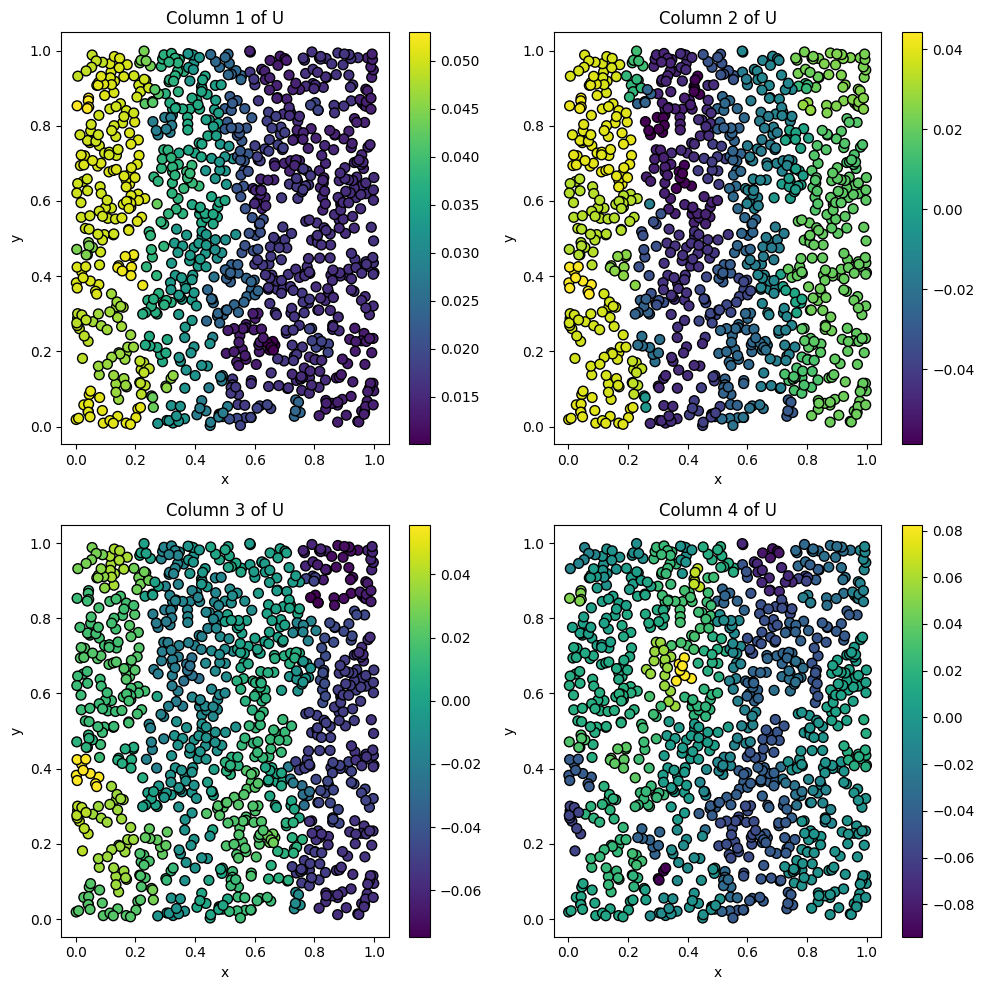

In [63]:
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

axes = axes.flatten()

for i in range(4):
    sc = axes[i].scatter(coords_df_4['x'], coords_df_4['y'], c=U_4[:, i], cmap='viridis', s=50, edgecolor='k')
    axes[i].set_title(f'Column {i + 1} of U')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    plt.colorbar(sc, ax=axes[i], orientation='vertical')

plt.tight_layout()
plt.show()

## K = 6

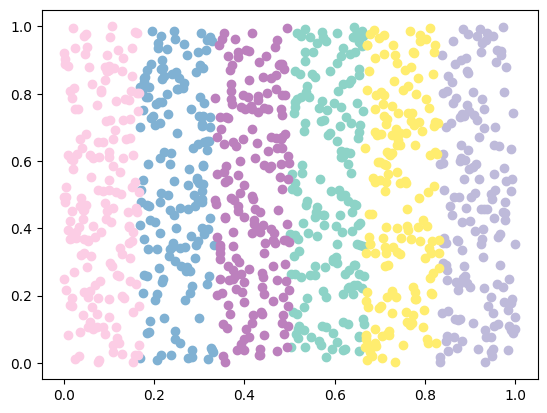

In [90]:
coords_df_6 = gen_model.generate_graph(100, 1000, 30, 6, 0.05)
gen_model.plot_scatter(coords_df_6)
W_6 = gen_model.generate_W_strong(coords_df_6, 100, 1000, 30, 6, 0.05) 
L_6 = np.diag(np.random.rand(min(W_6.shape)))
V_6, _ = np.linalg.qr(np.random.randn(30, W_6.shape[0]))
X_6 = W_6.T @ L_6 @ V_6.T
X_6 = X_6 + np.random.normal(0, 0.02, X_6.shape)
weights_6, edge_df_6 = gen_model.generate_weights_edge(coords_df_6, 3, 0.1)

In [91]:
model_hooi_6 = splsi_.SpLSI_(lamb_start=0.001,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-05,normalize=True,L_inv_=True)
model_hooi_6.fit(X_6, 6, edge_df_6, weights_6)

Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxclu

Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
SpatialSVD ran for 6 steps.
Running SPOC...


In [98]:
U_6 = model_hooi_6.U
V_hat_6 = model_hooi_6.V

In [99]:
L2_error_U_6 = utils.get_l2_err(W_6, U_6)
L2_error_V_6 = utils.get_l2_err(V_6.T, V_hat_6)
moran_score_6, _ = utils.moran(U_6, edge_df_6)
pas_score_6 = utils.get_PAS(U_6, edge_df_6)
print(f"L2 norm error between the true and predicted assignment matrices is {L2_error_U_6}")
print(f"L2 norm error between the true and predicted aV is {L2_error_V_6}")
print(f"Moran score for the predicted assignment matrices is {moran_score_6}")
print(f"Pas score for the predicted assignment matrices is {pas_score_6}")

L2 norm error between the true and predicted assignment matrices is 82.94055961530339
L2 norm error between the true and predicted aV is 13.549539276346119
Moran score for the predicted assignment matrices is 0.9442020704737776
Pas score for the predicted assignment matrices is 0.895


In [100]:
acc_6 = utils.group_and_compare(U_6, coords_df_6)
acc_6_spectral = utils.group_and_compare_spectral(U_6, coords_df_6)
print(f"Clustering Accuracy: {acc_6:.2f}")
print(f"Clustering Accuracy: {acc_6_spectral:.2f}")

Clustering Accuracy: 0.88
Clustering Accuracy: 0.87


In [101]:
U_66, _, _ = svds(X_6, k=6)
acc_6_pca = utils.group_and_compare(U_66, coords_df_6)
acc_6_pca_spectral = utils.group_and_compare_spectral(U_66, coords_df_6)
print(f"Clustering Accuracy: {acc_6_pca:.2f}")
print(f"Clustering Accuracy: {acc_6_pca_spectral:.2f}")

Clustering Accuracy: 0.50
Clustering Accuracy: 0.61


In [102]:
acc_6_hmrf = utils.hmrf_clustering(X_6, coords_df_6, 6)
print(f"Clustering Accuracy for HMRF: {acc_6_hmrf:.2f}")

Converged in 2 iterations.
Clustering Accuracy for HMRF: 0.61


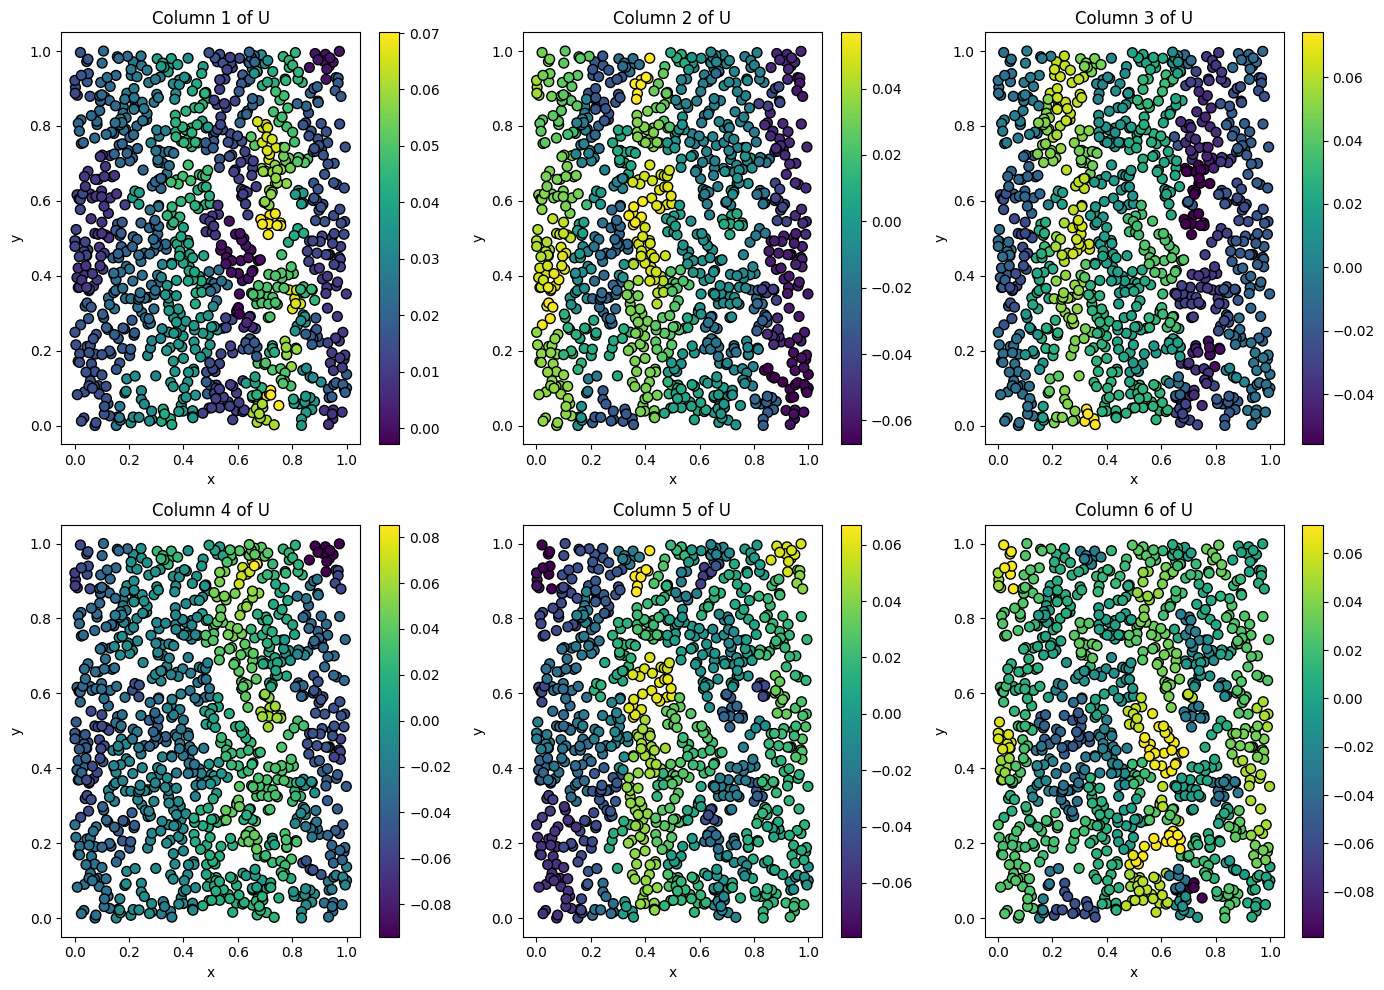

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(14, 10))

axes = axes.flatten()

for i in range(6):
    sc = axes[i].scatter(coords_df_6['x'], coords_df_6['y'], c=U_6[:, i], cmap='viridis', s=50, edgecolor='k')
    axes[i].set_title(f'Column {i + 1} of U')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    plt.colorbar(sc, ax=axes[i], orientation='vertical')

plt.tight_layout()
plt.show()

## K = 8

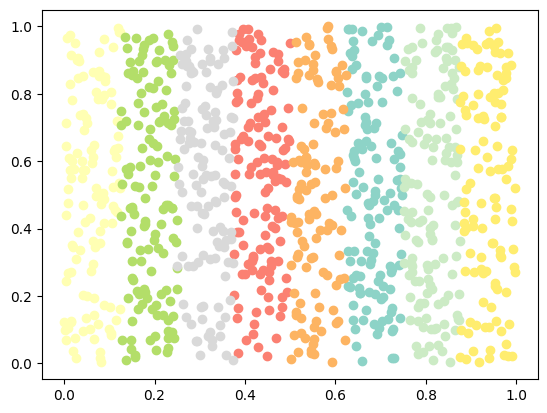

In [82]:
coords_df_8 = gen_model.generate_graph(100, 1000, 30, 8, 0.05)
gen_model.plot_scatter(coords_df_8)
W_8 = gen_model.generate_W_strong(coords_df_8, 100, 1000, 30, 8, 0.05) 
L_8 = np.diag(np.random.rand(min(W_8.shape)))
V_8, _ = np.linalg.qr(np.random.randn(30, W_8.shape[0]))
X_8 = W_8.T @ L_8 @ V_8.T
X_8 = X_8 + np.random.normal(0, 0.02, X_8.shape)
weights_8, edge_df_8 = gen_model.generate_weights_edge(coords_df_8, 3, 0.1)

In [83]:
model_hooi_8 = splsi_.SpLSI_(lamb_start=0.001,step_size=1.2,grid_len=29,method="hooi",verbose=0,eps=1e-05,normalize=True,L_inv_=True)
model_hooi_8.fit(X_8, 8, edge_df_8, weights_8)

Running spatial HOSVD...
Initializing..


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Optimal lambda is 0.038443359375...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
Taking L_inv...
Taking L_inv...


/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/admm.py:31: CholmodTypeConversionWarning: converting matrix of class csr_matrix to CSC format
  factor = cholesky(eye(n) + sigma * A @ A.T)
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]
/Users/zhangzeyu/Downloads/research/SpLSI/.venv/lib/python3.9/site-packages/pycvxcluster/algos/ssnal.py:345: RuntimeWarning: invalid value encountered in scalar divide
  dual_ratio = dualinf_sub / dualinf_hist[itersub - 1]


Normalizing...
Optimal lambda is 0.16484466236095108...
SpatialSVD ran for 3 steps.
Running SPOC...


In [84]:
U_8 = model_hooi_8.U
V_hat_8 = model_hooi_8.V

In [85]:
L2_error_U_8 = utils.get_l2_err(W_8, U_8)
L2_error_V_8 = utils.get_l2_err(V_8.T, V_hat_8)
moran_score_8, _ = utils.moran(U_8, edge_df_8)
pas_score_8 = utils.get_PAS(U_8, edge_df_8)
print(f"L2 norm error between the true and predicted assignment matrices is {L2_error_U_8}")
print(f"L2 norm error between the true and predicted aV is {L2_error_V_8}")
print(f"Moran score for the predicted assignment matrices is {moran_score_8}")
print(f"Pas score for the predicted assignment matrices is {pas_score_8}")

L2 norm error between the true and predicted assignment matrices is 105.841020281791
L2 norm error between the true and predicted aV is 11.778887965112684
Moran score for the predicted assignment matrices is 0.970125919108787
Pas score for the predicted assignment matrices is 0.92


In [86]:
acc_8 = utils.group_and_compare(U_8, coords_df_8)
acc_8_spectral = utils.group_and_compare_spectral(U_8, coords_df_8)
print(f"Clustering Accuracy: {acc_8:.2f}")
print(f"Clustering Accuracy: {acc_8_spectral:.2f}")

Clustering Accuracy: 0.92
Clustering Accuracy: 0.93


In [87]:
U_88, _, _ = svds(X_8, k=8)
acc_8_pca = utils.group_and_compare(U_88, coords_df_8)
acc_8_pca_spectral = utils.group_and_compare_spectral(U_88, coords_df_8)
print(f"Clustering Accuracy: {acc_8_pca:.2f}")
print(f"Clustering Accuracy: {acc_8_pca_spectral:.2f}")

Clustering Accuracy: 0.88
Clustering Accuracy: 0.87


In [88]:
acc_8_hmrf = utils.hmrf_clustering(X_8, coords_df_8, 8)
print(f"Clustering Accuracy for HMRF: {acc_8_hmrf:.2f}")

Converged in 2 iterations.
Clustering Accuracy for HMRF: 0.88


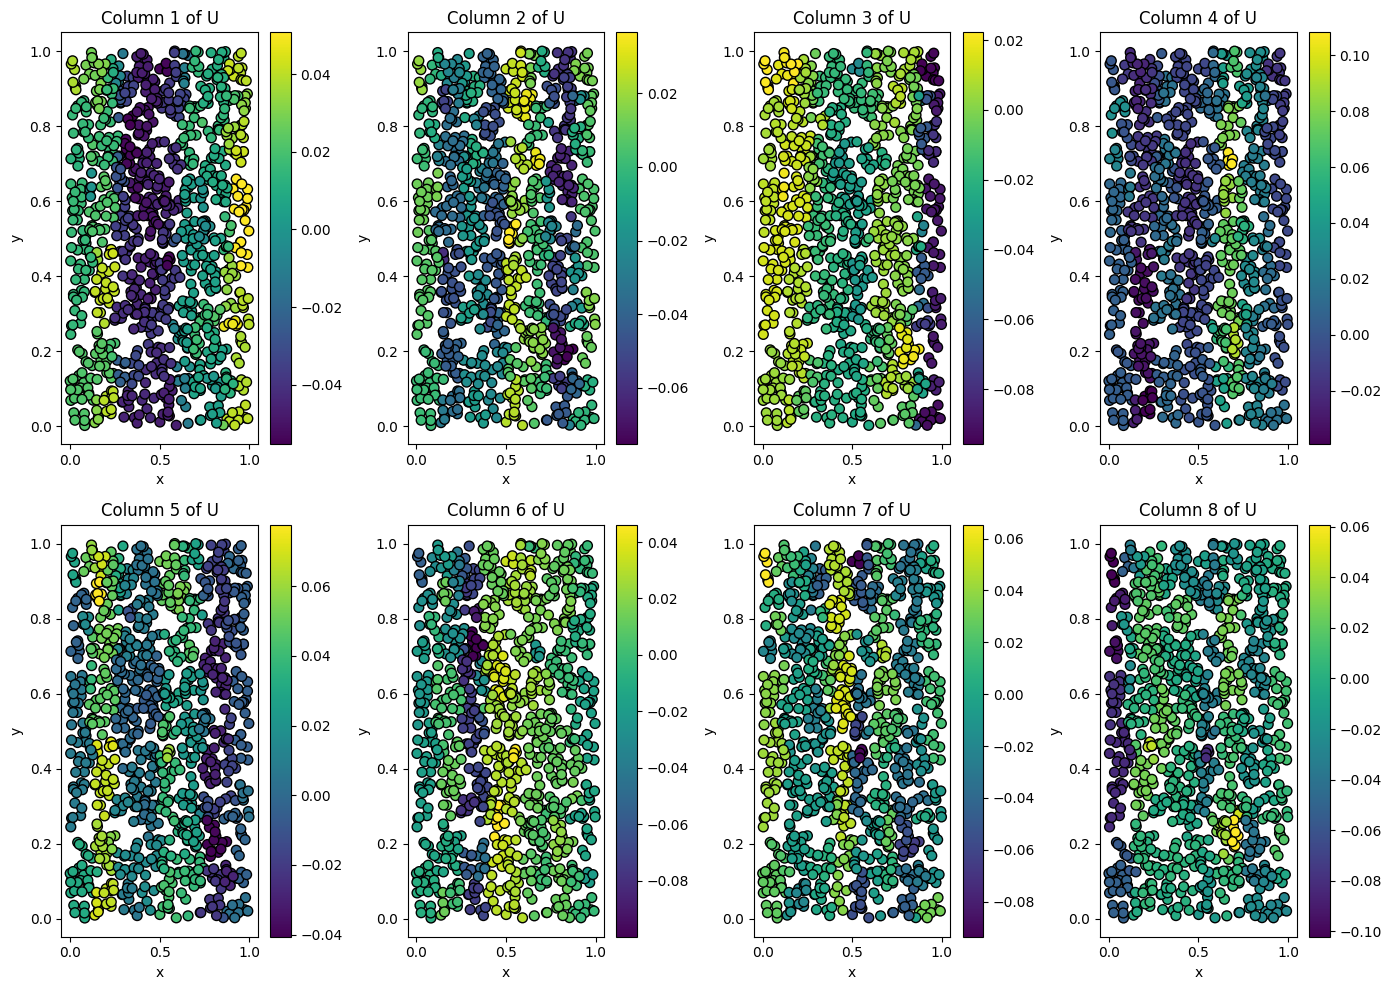

In [89]:
fig, axes = plt.subplots(2, 4, figsize=(14, 10))

axes = axes.flatten()

for i in range(8):
    sc = axes[i].scatter(coords_df_8['x'], coords_df_8['y'], c=U_8[:, i], cmap='viridis', s=50, edgecolor='k')
    axes[i].set_title(f'Column {i + 1} of U')
    axes[i].set_xlabel('x')
    axes[i].set_ylabel('y')
    plt.colorbar(sc, ax=axes[i], orientation='vertical')

plt.tight_layout()
plt.show()

In [ ]:
result_3 = simulation(k=3, iteration=5)

In [ ]:
result_4 = simulation(k=4, iteration=10)

In [ ]:
result_5 = simulation(k=5, iteration=10)

In [ ]:
result_6 = simulation(k=6, iteration=10)

In [ ]:
result_7 = simulation(k=7, iteration=10)

In [ ]:
result_8 = simulation(k=8, iteration=10)

In [ ]:
result_9 = simulation(k=9, iteration=10)

In [ ]:
result_10 = simulation(k=10, iteration=20)